In [8]:
import random
import gymnasium as gym
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard
from itertools import count

# Hyperparameters

In [ ]:
GAMMA = 0.995
ALPHA = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 100000
TARGET_UPDATE_EVERY = 1000
NUM_EPISODES = 1500
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 5000
UPDATE_EVERY = 4

# Environment

In [ ]:
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Experience tuple
Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return map(torch.tensor, zip(*batch))

    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.net(x)

def select_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return int(torch.argmax(policy_net(state_tensor)))

# Initialize networks and buffer
policy_net = QNetwork(state_size, action_size)
target_net = QNetwork(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=ALPHA)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

steps = 0
epsilon = EPS_START

episode_rewards = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, epsilon, policy_net)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.add(Experience(state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps += 1

        if len(replay_buffer) >= BATCH_SIZE and steps % UPDATE_EVERY == 0:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
            states = states.float()
            actions = actions.long()
            rewards = rewards.float()
            next_states = next_states.float()
            dones = dones.float()

            q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0]
                target_q = rewards + (GAMMA * max_next_q * (1 - dones))

            loss = nn.MSELoss()(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            optimizer.step()

        if steps % TARGET_UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(total_reward)

    # Check if environment is solved
    if len(episode_rewards) >= 100:
        av_latest_points = np.mean(episode_rewards[-100:])
        if av_latest_points >= 200.0:
            print(f"\n\nEnvironment solved in {episode + 1} episodes!")
            torch.save(policy_net.state_dict(), "lunar_lander_model.pth")
            break

    epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-episode / (EPS_DECAY / NUM_EPISODES))

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg (last 10): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

print("Training complete.")


Episode 0, Reward: -92.54, Avg (last 10): -92.54, Epsilon: 1.000
Episode 10, Reward: -366.02, Avg (last 10): -323.75, Epsilon: 0.059
Episode 20, Reward: -91.45, Avg (last 10): -200.81, Epsilon: 0.012
Episode 30, Reward: -67.77, Avg (last 10): -70.62, Epsilon: 0.010
Episode 40, Reward: -24.44, Avg (last 10): -51.48, Epsilon: 0.010
Episode 50, Reward: -20.26, Avg (last 10): -41.44, Epsilon: 0.010
Episode 60, Reward: -55.66, Avg (last 10): -48.62, Epsilon: 0.010
Episode 70, Reward: -21.54, Avg (last 10): -64.65, Epsilon: 0.010
Episode 80, Reward: -12.60, Avg (last 10): -22.76, Epsilon: 0.010
Episode 90, Reward: -103.40, Avg (last 10): -64.72, Epsilon: 0.010
Episode 100, Reward: -131.81, Avg (last 10): -108.63, Epsilon: 0.010
Episode 110, Reward: 20.93, Avg (last 10): -64.90, Epsilon: 0.010
Episode 120, Reward: -52.56, Avg (last 10): -37.57, Epsilon: 0.010
Episode 130, Reward: -52.75, Avg (last 10): -51.14, Epsilon: 0.010
Episode 140, Reward: -61.73, Avg (last 10): -24.80, Epsilon: 0.010
E

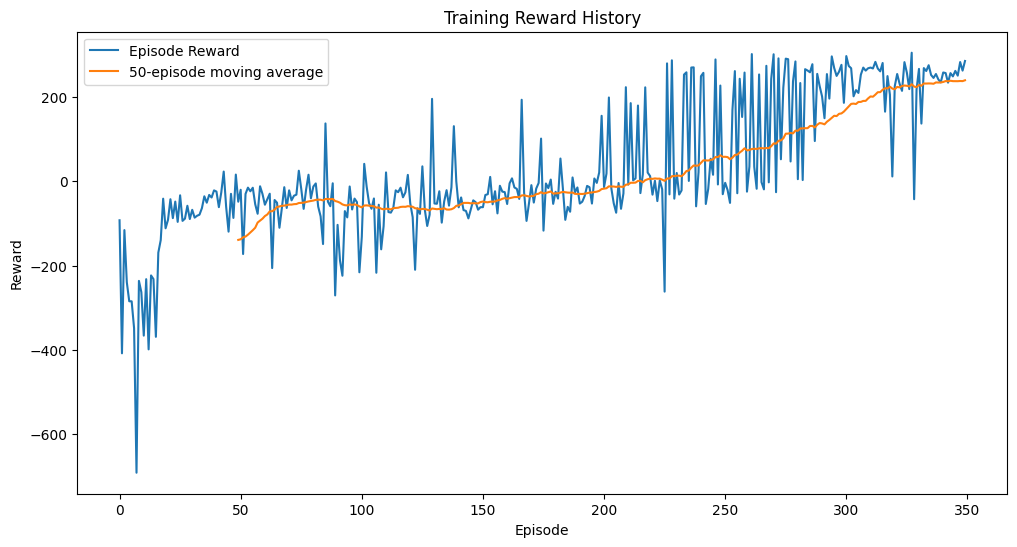

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(episode_rewards, label="Episode Reward")
# Optionally, smooth with a rolling average (window=50)
window = 50
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window - 1, len(episode_rewards)), smoothed, label=f"{window}-episode moving average")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Reward History")
plt.legend()
plt.show()

In [32]:

from gym.wrappers.monitoring.video_recorder import VideoRecorder

def create_video(filename, env, policy_net):
    """
    Creates a video of an agent interacting with a Gym environment using Gym's video recording feature.

    Args:
        filename (str): Path to save the video file.
        env (gym.Env): Gym environment instance.
        policy_net (torch.nn.Module): PyTorch model mapping states to Q-values.
    """
    video = VideoRecorder(env, filename)
    done = False
    state, _ = env.reset()
    
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        action = int(torch.argmax(q_values).item())

        video.capture_frame()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state

    video.close()
    env.close()

# Example usage:
if __name__ == "__main__":
    env = gym.make('LunarLander-v3', render_mode='rgb_array')
    
    # Load your trained model weights
    policy_net = QNetwork(env.observation_space.shape[0], env.action_space.n)
    policy_net.load_state_dict(torch.load("lunar_lander_model.pth"))
    policy_net.eval()

    create_video("trained_agent.mp4", env, policy_net)


MoviePy - Building video trained_agent.mp4.
MoviePy - Writing video trained_agent.mp4



MoviePy - Done !
MoviePy - video ready trained_agent.mp4
